In [182]:
import pandas as pd
import numpy as np
import json
import statsmodels.formula.api as sm
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries I'm using to get, plot, and run some basic regressions on the data

#### Functions


In [263]:
#Make Graph Dimensions
dimss = (12, 7)
def setdimension(x):
    fig, ax = plt.subplots(figsize=x)

#Plot a normal line graph
def linegraph(y,z):
    y.plot(figsize = dimss, grid = True)
    plt.title(z)
    plt.show()

#Create a summary table including the t statistic
def summarystats(p):
    s = p.describe().T
    #using the statistics from "describe().T" I create the t statistic using the standard formula
    s['tstat'] = s['mean']/(s['std']/np.sqrt(s['count']))
    return s[['mean','std','tstat']].T

#Run a simple OLS regression
def olsreg(a,b,d):
    y = d[a]
    x = d[b]
    result = sm.ols(formula="y ~ x", data=d).fit()
    return result.summary()

#Drop NaN data and show tail of data frame
def dropnan(d):
    d.dropna()
    return d.tail()

#Check for outliers
def chkout(a,d):
    std_ = d[a].std()
    min_outlier_ = d[a].mean() - (std_ * 3)
    max_outlier_ = d[a].mean() + (std_ * 3)
    return (d[a].where(d[a]>=max_outlier_).count(), d[a].where(d[a]<=min_outlier_).count())
#returns the number of outliers abouve and below 3 standard deviations from the mean.

## Dataset 1 (CSV)

My first data set will come from CRSP, the Center for Research in Security Pricing. I will work with a data set containing monthly prices of various securities from the NYSE from 1960 - 1990.

The question I see to answer is the following: Did companies with a greater number of shares outstanding typically report better earnings than other companies?

In [295]:
df1 = pd.read_csv('06-mstk.csv',parse_dates=['caldt'])
df1.tail(10)

,permno,caldt,ret,shr,cumfacshr,me_lag,prc_lag
0,10006,1960-01-01,0.005155,1418,6.0,68.77300,48.500
1,10006,1960-02-01,0.046154,1418,6.0,69.12750,48.750
2,10006,1960-03-01,-0.059553,1418,6.0,71.43175,50.375
3,10006,1960-04-01,-0.081794,1418,6.0,67.17775,47.375
4,10006,1960-05-01,0.048851,1418,6.0,61.68300,43.500
5,10006,1960-06-01,0.027778,1418,6.0,63.81000,45.000
6,10006,1960-07-01,-0.013514,1418,6.0,65.58250,46.250
7,10006,1960-08-01,-0.021918,1418,6.0,64.69625,45.625
8,10006,1960-09-01,-0.142045,1418,6.0,62.39200,44.000
9,10006,1960-10-01,-0.013245,1418,6.0,53.52950,37.750


I will get rid of any missing values. I don't expect there to be any, so I'll check the number of observations to see if it changes.

In [270]:
dropnan(df1)

,permno,caldt,ret,shr,cumfacshr,me_lag,prc_lag
487573,93201,1989-09-01,0.035088,14790,1.0,104.85150,7.125
487574,93201,1989-10-01,0.050847,14790,1.0,109.07625,7.375
487575,93201,1989-11-01,0.209677,14790,1.0,114.62250,7.750
487576,93201,1989-12-01,0.040000,14843,1.0,138.65625,9.375
487577,93201,1990-01-01,0.012821,14843,1.0,144.71925,9.750


The number of observations remained constant.

Next I will check for outliers.

In [272]:
chkout('ret',df1)

(4493, 1911)

Not surprisingly, there are a large number of outliers. Since companies can go up or down in value very quickly, outliers over a 30 year period is to be expected. Because these are still real companies, I will choose to maintain them in my dataset. 

Next I'll describe the data.

In [273]:
df1.describe()

,permno,ret,shr,cumfacshr,me_lag,prc_lag
count,487578.000000,486368.000000,4.875780e+05,487578.000000,486371.000000,486702.000000
mean,32795.253701,0.011139,2.012246e+04,6.303042,734.858245,29.504696
std,16113.715318,0.109387,4.665970e+04,23.660594,2528.511240,56.255072
min,10006.000000,-0.890625,9.900000e+01,0.001333,0.105938,0.000000
25%,20415.000000,-0.047904,3.181000e+03,1.000000,55.514250,14.750000
50%,26913.000000,0.004348,7.333000e+03,2.000000,162.540000,24.250000
75%,45129.000000,0.062828,1.949600e+04,4.000000,549.097000,37.000000
max,93201.000000,11.000000,1.426344e+06,1152.000000,102022.285125,8675.000000


This looks right. Companies improve a little month to month on average.

It is common in academic financial circles to get rid of securities which have a price of less than $5, as this generally just adds noise. I will follow in their footsteps and do the same.

In [274]:
df1 = df1.query("prc_lag >= 5").reset_index(drop=True)
df1.head(10)

,permno,caldt,ret,shr,cumfacshr,me_lag,prc_lag
0,10006,1960-01-01,0.005155,1418,6.0,68.77300,48.500
1,10006,1960-02-01,0.046154,1418,6.0,69.12750,48.750
2,10006,1960-03-01,-0.059553,1418,6.0,71.43175,50.375
3,10006,1960-04-01,-0.081794,1418,6.0,67.17775,47.375
4,10006,1960-05-01,0.048851,1418,6.0,61.68300,43.500
5,10006,1960-06-01,0.027778,1418,6.0,63.81000,45.000
6,10006,1960-07-01,-0.013514,1418,6.0,65.58250,46.250
7,10006,1960-08-01,-0.021918,1418,6.0,64.69625,45.625
8,10006,1960-09-01,-0.142045,1418,6.0,62.39200,44.000
9,10006,1960-10-01,-0.013245,1418,6.0,53.52950,37.750


Now, to start answering the question. I will use two apporaches. First, I will split the data into 5 subsets based on their shares oustanding percentile. Then I will create a new segment of the difference between high share and low share companies, upon which I will use a t-test to see if the difference is negligble. Afterwards I will also run a simple OLS regression.

In [248]:
df1['segment'] = df1.groupby('caldt')['shr'].transform(pd.qcut,5,labels=False,)
df1.head()

,permno,caldt,ret,shr,cumfacshr,me_lag,prc_lag,segment
0,10006,1960-01-01,0.005155,1418,6.0,68.77300,48.500,1
1,10006,1960-02-01,0.046154,1418,6.0,69.12750,48.750,1
2,10006,1960-03-01,-0.059553,1418,6.0,71.43175,50.375,1
3,10006,1960-04-01,-0.081794,1418,6.0,67.17775,47.375,1
4,10006,1960-05-01,0.048851,1418,6.0,61.68300,43.500,1


In [250]:
df1_pivot = df1.pivot_table('ret',index='caldt',columns='segment',aggfunc='mean')

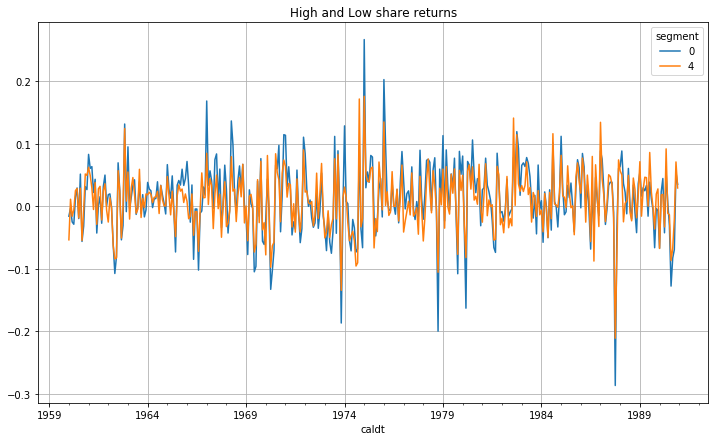

In [298]:
d = df1_pivot.drop([1,2,3], 1)
linegraph(d, "High and Low share returns")

Above we see the low share company returns (blue) and the high share company returns (orange). It seems they are pretty similar, but the low share companies tend to have a greater variance.

In [149]:
df1_pivot['5'] = df1_pivot[4] - df1_pivot[0]
summarystats(df1_pivot)
#"5" will be the name of the segment composed of differences

segment,0,1,2,3,4,5
mean,0.013085,0.011532,0.010896,0.010342,0.008999,-0.004086
std,0.056874,0.060498,0.056385,0.053316,0.046213,0.027916
tstat,4.437554,3.676416,3.727275,3.741176,3.755839,-2.823199


It seems that higher share companies on average did a little worse than lower share companies. 

Next I will run an OLS regression, to see if the oustanding shares variable was coorelated with returns in a significant way.

In [299]:
olsreg('ret','shr',df1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.147
Date:                Tue, 02 Oct 2018   Prob (F-statistic):             0.0132
Time:                        14:28:38   Log-Likelihood:             3.8614e+05
No. Observations:              486368   AIC:                        -7.723e+05
Df Residuals:                  486366   BIC:                        -7.723e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0113      0.000     66.191      0.000       0.011       0.012
x          -8.326e-09   3.36e-09     -2.479      0.013   -1.49e-08   -1.74e-09
==============================================================================
Omnibus:                   451480.559   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1011653144.363
Skew:                           3.219   Prob(JB):                         0.00
Kurtosis:                     226.336   Cond. No.                     5.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It seems the oustanding shares variable is moderatley significant. While I do not think this relationship is causal, it is interesting to note the coorelation.

## Dataset 2 (JSON)

This next dataset comes from google trends. I wish to examine the relationship between the popularity of the show "breaking bad" and searches for "how to make cocaine."

In [276]:
df2 = pd.read_json('cocaine.json')
df2

,Week,breaking bad,how to make cocaine
0,2004-01,<1,84
1,2004-02,<1,93
2,2004-03,<1,89
3,2004-04,<1,48
4,2004-05,<1,93
5,2004-06,<1,79
6,2004-07,<1,56
7,2004-08,<1,78
8,2004-09,<1,65
9,2004-10,<1,71


This is a data set small enough we could actually just go through and check for missing variables, but to make use of our "dropnan" function we'll drop and missing observations to see if it makes a difference.

In [277]:
dropnan(df2)

,Week,breaking bad,how to make cocaine
172,2018-05,3,32
173,2018-06,3,31
174,2018-07,4,37
175,2018-08,4,28
176,2018-09,3,34


There are the same number of observations, so we know there was no missing data.

In [278]:
df2[['breaking bad']].describe()

,breaking bad
count,177
unique,25
top,<1
freq,51


We note that pandas registers "<1" as a string

In [279]:
df2[['how to make cocaine']].describe()

,how to make cocaine
count,177.000000
mean,56.954802
std,16.249762
min,28.000000
25%,44.000000
50%,54.000000
75%,69.000000
max,100.000000


We'll replace <1 with the integer "0", as this is what it likely represents and to get all integers so we can run a regression.

In [300]:
df2['breaking bad'] = pd.to_numeric(df2['breaking bad'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
# The above command will take all strings and replace them with '0'. Since '<1' is the only string, this solves the problem
df2.head(10)

,Week,breaking bad,how to make cocaine
0,2004-01,0,84
1,2004-02,0,93
2,2004-03,0,89
3,2004-04,0,48
4,2004-05,0,93
5,2004-06,0,79
6,2004-07,0,56
7,2004-08,0,78
8,2004-09,0,65
9,2004-10,0,71


In [281]:
df2.describe()

,breaking bad,how to make cocaine
count,177.000000,177.000000
mean,5.694915,56.954802
std,10.602188,16.249762
min,0.000000,28.000000
25%,0.000000,44.000000
50%,3.000000,54.000000
75%,6.000000,69.000000
max,100.000000,100.000000


Now everything is an integer!

Next we check for outliers:

In [282]:
chkout('breaking bad', df2)

(3, 0)

In [283]:
chkout('how to make cocaine', df2)

(0, 0)

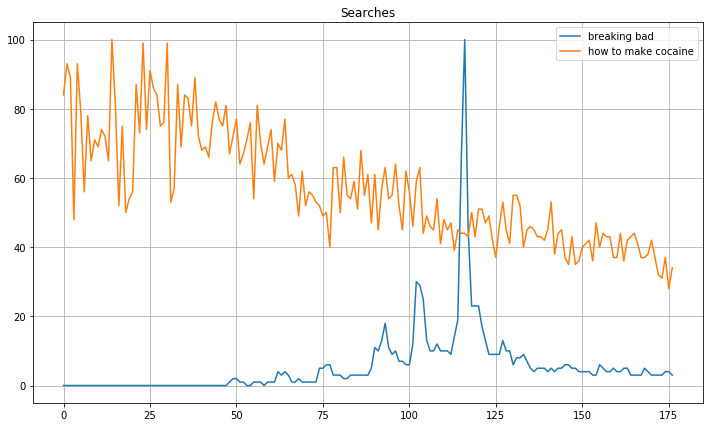

In [302]:
linegraph(df2,"Searches")

There are clearly weeks where breaking bad was more popular than others. Again however, I'm not worried about these outliers becasue I'm using searches as a proxy for popularity of the show, and there were times when it was more popular than others.

Now I'll run an OLS regression to see if there is significant coorelation.

In [285]:
olsreg('how to make cocaine', 'breaking bad', df2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     17.50
Date:                Tue, 02 Oct 2018   Prob (F-statistic):           4.53e-05
Time:                        14:04:35   Log-Likelihood:                -735.70
No. Observations:                 177   AIC:                             1475.
Df Residuals:                     175   BIC:                             1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.5868      1.327     44.919      0.000      56.969      62.205
x             -0.4622      0.110     -4.184      0.000      -0.680      -0.244
==============================================================================
Omnibus:                        8.917   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.423
Skew:                           0.477   Prob(JB):                       0.0148
Kurtosis:                       2.517   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It seems there was some corelation, but I think that is just because the searches for "How to make cocaine have gone down over time." To get a slightly better guess, I'll drop observations before breaking bad was being searched for.

In [286]:
df2_adjusted = df2.iloc[47:]
olsreg('how to make cocaine', 'breaking bad', df2_adjusted)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.752
Date:                Tue, 02 Oct 2018   Prob (F-statistic):             0.0996
Time:                        14:04:43   Log-Likelihood:                -500.43
No. Observations:                 130   AIC:                             1005.
Df Residuals:                     128   BIC:                             1011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.4994      1.206     42.701      0.000      49.113      53.886
x             -0.1428      0.086     -1.659      0.100      -0.313       0.028
==============================================================================
Omnibus:                        6.501   Durbin-Watson:                   0.573
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.716
Skew:                           0.536   Prob(JB):                       0.0348
Kurtosis:                       2.696   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There still exists a negative coorelation, though not very significant. I doubt this is causal.

## Dataset 3 (API)

The final dataset comes from Alpha Vantage, and gives real time minute by minute stock prices. I want to know if a higher volume of shares trading for Spotify is coorelated with the price increasing or decreasing.

In [305]:
ts=TimeSeries(key='WL1UQ2DWQZ9DZXNT', output_format='pandas')
df3, meta_data=ts.get_intraday(symbol='SPOT',interval='1min', outputsize='full')
df3.describe()

,1. open,2. high,3. low,4. close,5. volume
count,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000
mean,181.817143,181.841226,181.793295,181.817133,2882.391142
std,1.849248,1.852918,1.846919,1.850573,3500.653405
min,178.070000,178.110000,178.070000,178.110000,130.000000
25%,180.525000,180.525000,180.510000,180.510000,936.500000
50%,182.000000,182.010000,181.976700,181.991000,1746.000000
75%,182.987500,183.000000,182.955000,182.974500,3375.500000
max,185.900000,185.900000,185.900000,185.900000,42892.000000


In [306]:
dropnan(df3)

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2018-10-02 15:55:00,178.96,178.96,178.850,178.850,5459.0
2018-10-02 15:56:00,178.92,178.93,178.830,178.930,4802.0
2018-10-02 15:57:00,178.82,178.88,178.727,178.727,9387.0
2018-10-02 15:58:00,178.85,178.85,178.810,178.840,5507.0
2018-10-02 15:59:00,178.81,179.00,178.810,179.000,23178.0


We note that there were no missing values

In [307]:
chkout('4. close',df3)

(0, 0)

In [308]:
chkout('5. volume',df3)

(34, 0)

There were no outliers for closing prices, but there were for volume. As with the other datasets, I choose to include them anyway becasue this is acutal market data and will possibly contribute to answering the question posed.

In [309]:
df3.describe()

,1. open,2. high,3. low,4. close,5. volume
count,1603.000000,1603.000000,1603.000000,1603.000000,1603.000000
mean,181.817143,181.841226,181.793295,181.817133,2882.391142
std,1.849248,1.852918,1.846919,1.850573,3500.653405
min,178.070000,178.110000,178.070000,178.110000,130.000000
25%,180.525000,180.525000,180.510000,180.510000,936.500000
50%,182.000000,182.010000,181.976700,181.991000,1746.000000
75%,182.987500,183.000000,182.955000,182.974500,3375.500000
max,185.900000,185.900000,185.900000,185.900000,42892.000000


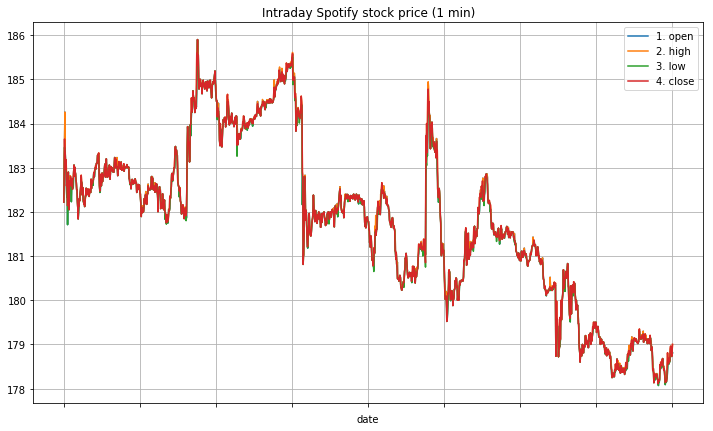

In [310]:
prices=df3.drop('5. volume', 1)
linegraph(prices, 'Intraday Spotify stock price (1 min)')

Interesting graph of minute by minute prices over the past few days. It seems the price has been dropping overall.

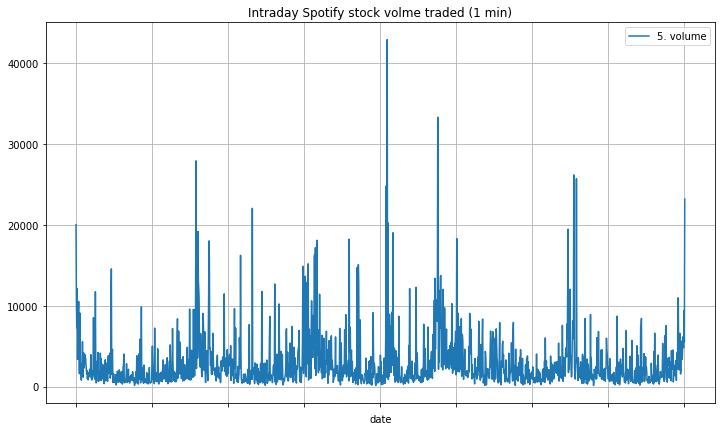

In [311]:
volume=df3.drop(['1. open', '2. high', '3. low', '4. close'], 1)
linegraph(volume, 'Intraday Spotify stock volme traded (1 min)')

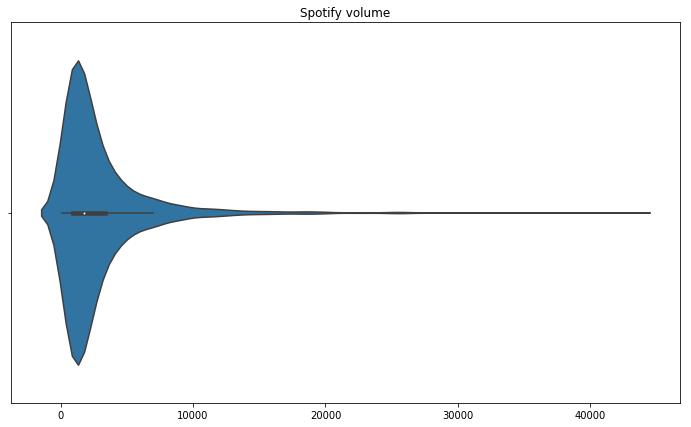

In [312]:
fig, ax = plt.subplots(figsize=dimss)
sns.violinplot(volume)
plt.title('Spotify volume')
plt.show()

Graphs showing the volume of trades.

First I'll look to see if when there were more than 10000 shares trading there was a difference from how ir traded on average.

In [313]:
df3['ret'] = df3['4. close'] - df3['4. close'].mean()
df3['high_vol'] = (df3['5. volume']>=10000).astype(int)
high_v = df3.pivot_table('ret',index='date',columns='high_vol')
summarystats(high_v)

high_vol,0,1
mean,-0.021683,0.504943
std,1.849949,1.806057
tstat,-0.459504,2.271344


A positive coefficient and a t-statistic larger than 2 implies that higher volume trades tend to push the price upwards.

NExt I'll run an OLS regression to see the impact the volume of trading has on returns.

In [315]:
olsreg('ret','5. volume',df3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.263
Date:                Tue, 02 Oct 2018   Prob (F-statistic):             0.0391
Time:                        14:48:58   Log-Likelihood:                -3258.6
No. Observations:                1603   AIC:                             6521.
Df Residuals:                    1601   BIC:                             6532.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0785      0.060     -1.313      0.190      -0.196       0.039
x           2.724e-05   1.32e-05      2.065      0.039    1.36e-06    5.31e-05
==============================================================================
Omnibus:                      104.969   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.150
Skew:                          -0.128   Prob(JB):                     1.16e-09
Kurtosis:                       2.258   Cond. No.                     5.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Again we see that high volume tends to increase returns for Spotify over these last few days.

That's my project! Thanks for grading it!